# Session 2 - Machine Learning (ML) Exploratory Data Analysis

This is an introductory notebook to familiarize yourself with Exploratory Data Analysis techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms.

The intent of this notebook is three-fold. First an Exploratory Data Analysis (EDA) is conducted to visualise the optical data of the MODIS instrument and the distribution of this tabular dataset across water pixels. Next, this notebook briefly reviews the correlation of some of these spectral bands in the task of water classification. Finally, we introduce the topic of feature engineering and outlier detection that might be of use for other applications. The entire work is done using the Python programming language and based on a dataset uploaded to [Hugging Face](https://huggingface.co/datasets/nasa-cisto-data-science-group/modis-lake-powell-toy-dataset).

**Author**: Jordan A. Caraballo-Vega  
**Release Date**: 2023.04.08  
**Last Modified**: 2024.04.10

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.

In [1]:
!pip install datasets shap lime

In [2]:
import os
import sys
import csv
import glob
import joblib
import datasets
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [3]:
# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our EDA visualizations.

In [4]:
os.makedirs('output', exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:
  - Read in data to a Dataframe
  - Drop unnecessary columns
  - Split into Xs and Ys

In [5]:
%%time
dataset = datasets.load_dataset(DATASET_URL, split='train')
df_pandas = pd.DataFrame(dataset)
df_pandas.head()

CPU times: user 964 ms, sys: 29.9 ms, total: 994 ms
Wall time: 7.49 s


water  sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  sur_refl_b04_1  \
0      0            2031            3113             776            1200   
1      1             410             494             183             319   
2      0            1609            2615             797            1000   
3      0            2593            3315            1250            1944   
4      0            2485            3365             905            1527   

   sur_refl_b05_1  sur_refl_b06_1  sur_refl_b07_1  ndvi  ndwi1  ndwi2  
0            3626            3480            2957  2103   -556    257  
1             295             329             307   929   2004   2334  
2            2143            1708            1107  2381   2098   4051  
3            3923            4194            3909  1222  -1170   -822  
4            4520            4646            4137  1504  -1599  -1029

## 4. EDA

In [6]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           800 non-null    int64
 1   sur_refl_b01_1  800 non-null    int64
 2   sur_refl_b02_1  800 non-null    int64
 3   sur_refl_b03_1  800 non-null    int64
 4   sur_refl_b04_1  800 non-null    int64
 5   sur_refl_b05_1  800 non-null    int64
 6   sur_refl_b06_1  800 non-null    int64
 7   sur_refl_b07_1  800 non-null    int64
 8   ndvi            800 non-null    int64
 9   ndwi1           800 non-null    int64
 10  ndwi2           800 non-null    int64
dtypes: int64(11)
memory usage: 68.9 KB


In [7]:
df_pandas.describe().T

count        mean          std     min      25%     50%  \
water           800.0     0.50625     0.500274     0.0     0.00     1.0   
sur_refl_b01_1  800.0  1209.75875  1287.886517     8.0   238.25   886.5   
sur_refl_b02_1  800.0  1577.25375  1554.828794     1.0   168.00  1394.0   
sur_refl_b03_1  800.0   743.00000  1004.334475  -100.0   286.00   540.0   
sur_refl_b04_1  800.0  1028.39500  1065.582946     6.0   413.00   809.5   
sur_refl_b05_1  800.0  1969.37125  1467.613243   -92.0   553.50  1818.5   
sur_refl_b06_1  800.0  1932.65875  1541.910775    51.0   511.25  1498.5   
sur_refl_b07_1  800.0  1587.69625  1395.266352     0.0   316.75  1174.0   
ndvi            800.0    87.13125  2518.736818 -9493.0 -1533.00   733.5   
ndwi1           800.0 -2336.03750  3404.038705 -9862.0 -4577.50 -1582.0   
ndwi2           800.0  -914.29125  3863.695634 -9692.0 -2846.25  -703.5   

                    75%      max  
water              1.00      1.0  
sur_refl_b01_1  1893.25   9222.0  
sur_refl_b02_1  2667.75   8837.0  
sur_refl_b03_1   857.00   8909.0  
sur_refl_b04_1  1313.25   9162.0  
sur_refl_b05_1  3210.75   6382.0  
sur_refl_b06_1  3254.25   6610.0  
sur_refl_b07_1  2672.00   6128.0  
ndvi            1729.50   8587.0  
ndwi1           -766.50   8823.0  
ndwi2            869.00  10000.0

In [8]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df_pandas.sample(frac=0.1)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 663 to 326
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           80 non-null     int64
 1   sur_refl_b01_1  80 non-null     int64
 2   sur_refl_b02_1  80 non-null     int64
 3   sur_refl_b03_1  80 non-null     int64
 4   sur_refl_b04_1  80 non-null     int64
 5   sur_refl_b05_1  80 non-null     int64
 6   sur_refl_b06_1  80 non-null     int64
 7   sur_refl_b07_1  80 non-null     int64
 8   ndvi            80 non-null     int64
 9   ndwi1           80 non-null     int64
 10  ndwi2           80 non-null     int64
dtypes: int64(11)
memory usage: 7.5 KB


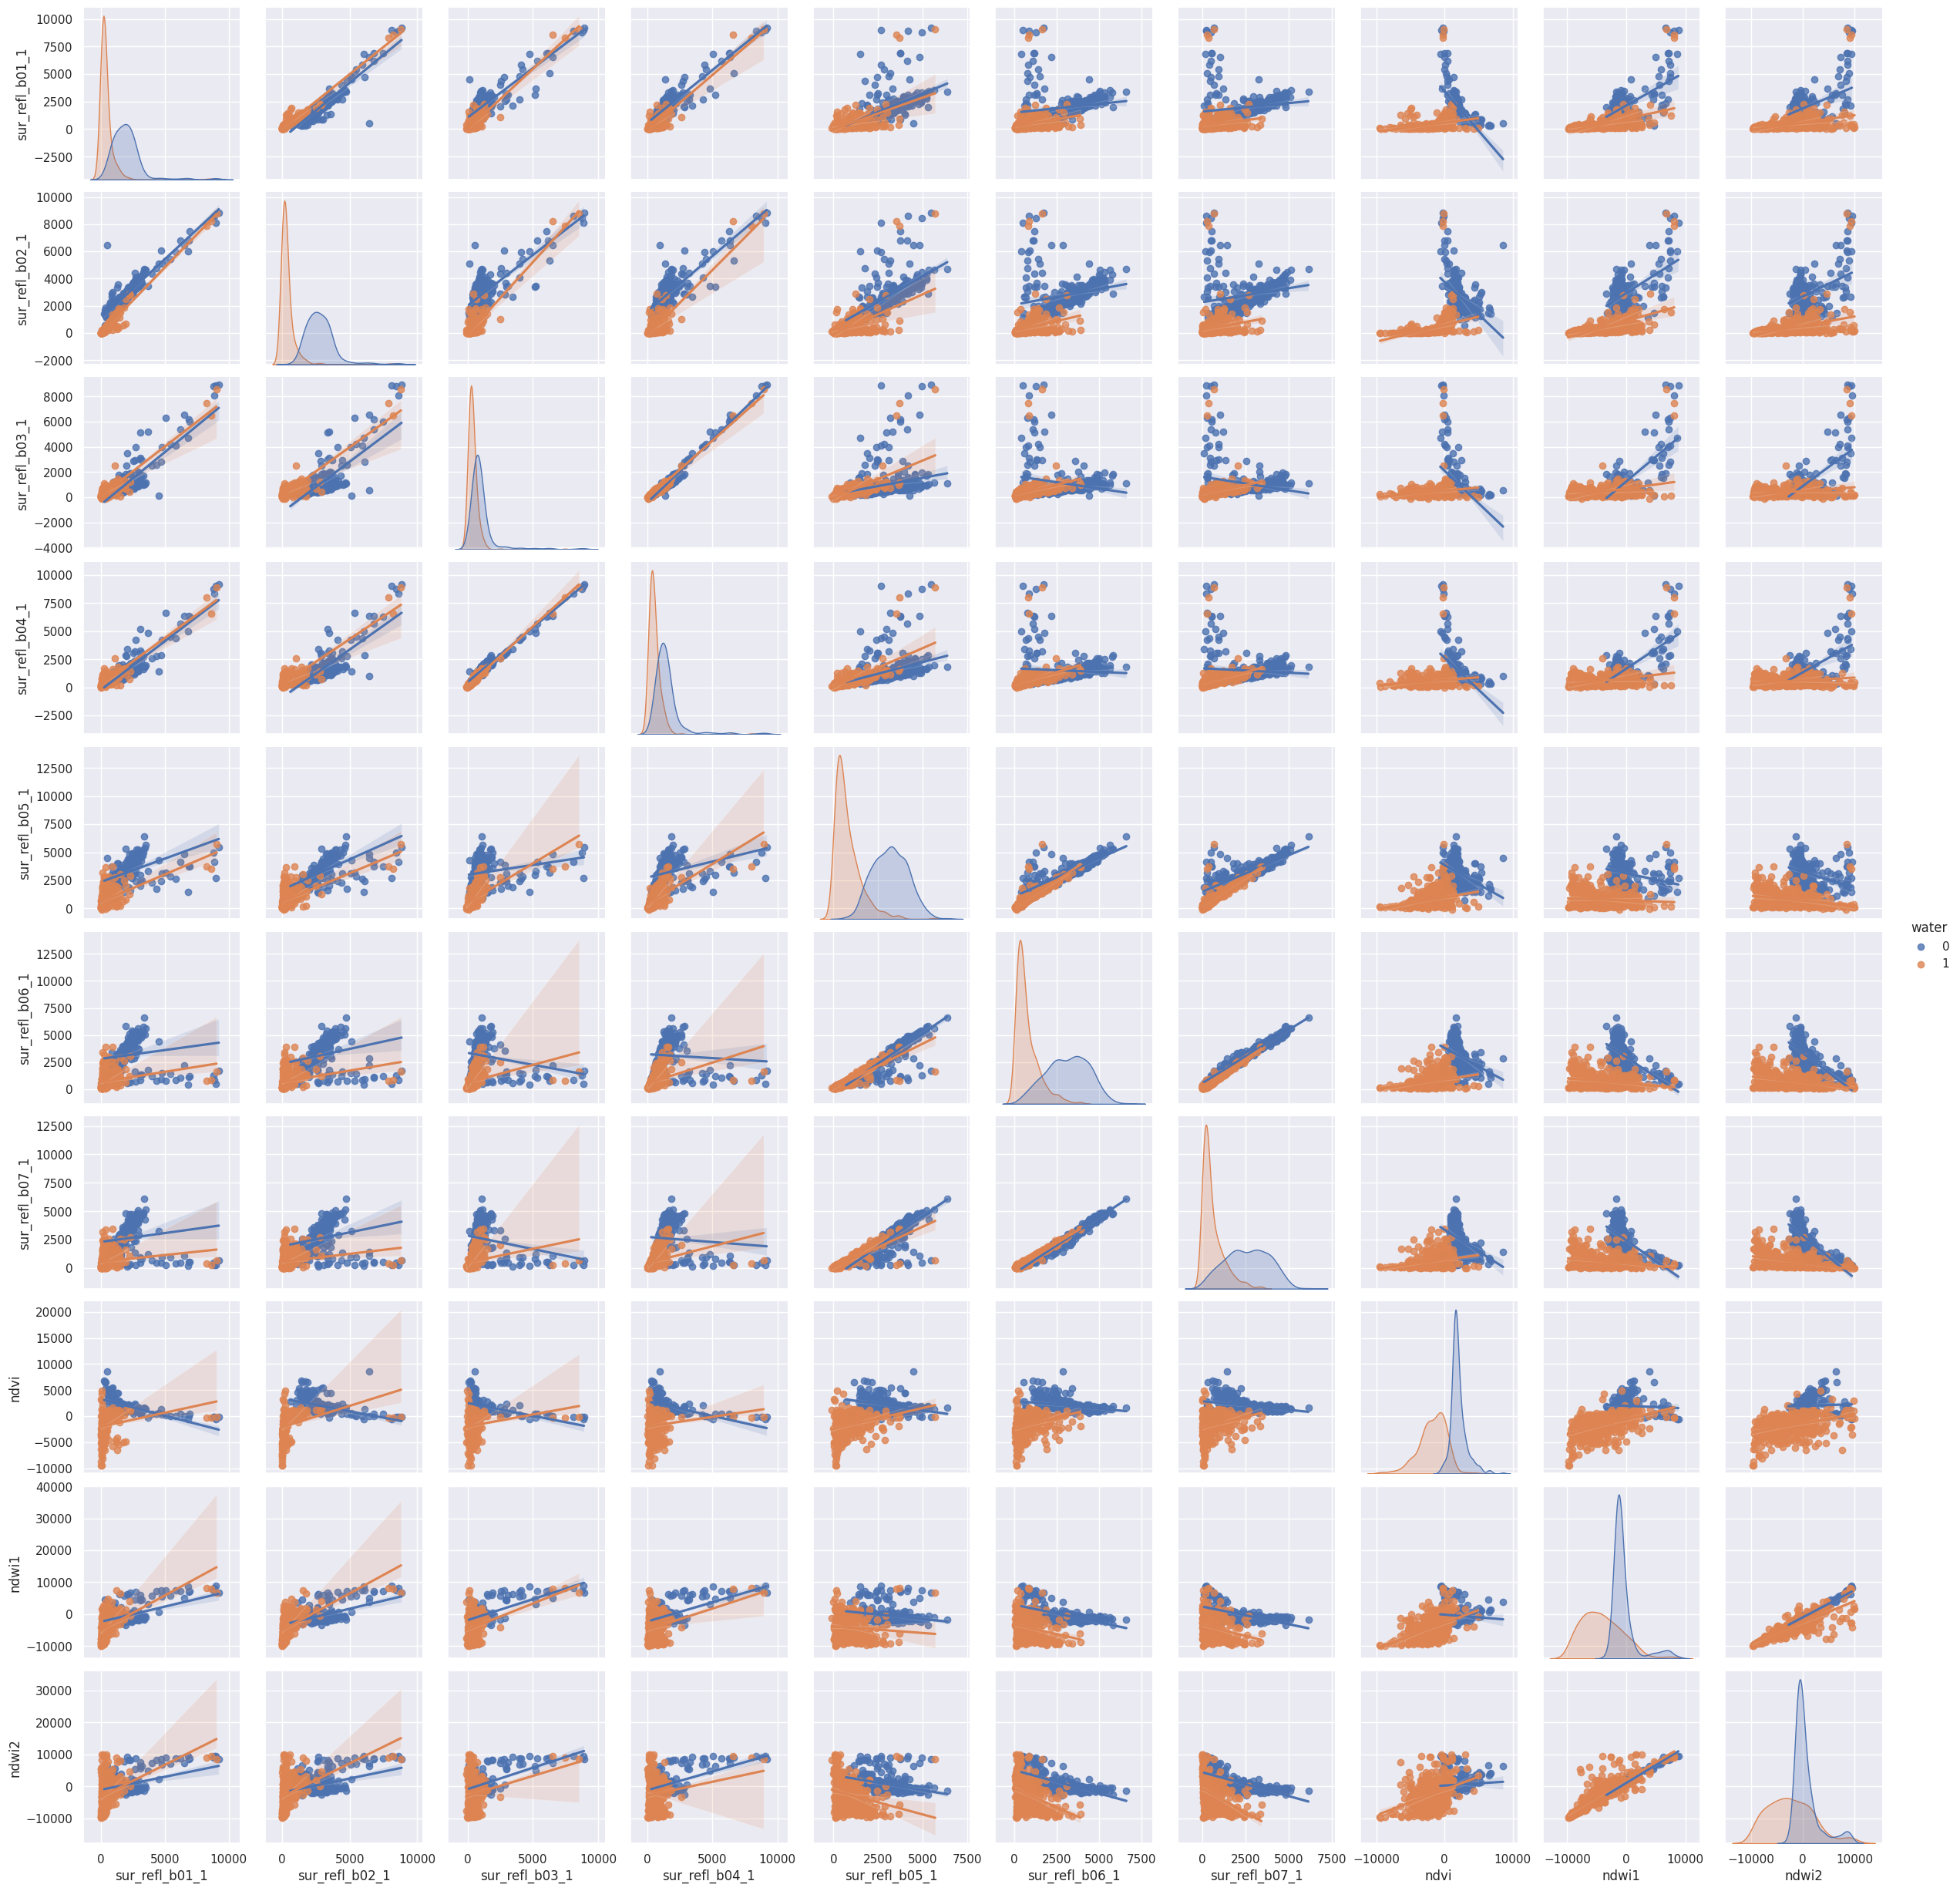

In [9]:
sns.set()
sns.pairplot(df_pandas, hue='water', kind='reg')
plt.savefig('output/modisWaterTrainingEDA_Correlation_WaterHighlight.png')

array([[<Axes: title={'center': 'water'}>,
        <Axes: title={'center': 'sur_refl_b01_1'}>,
        <Axes: title={'center': 'sur_refl_b02_1'}>],
       [<Axes: title={'center': 'sur_refl_b03_1'}>,
        <Axes: title={'center': 'sur_refl_b04_1'}>,
        <Axes: title={'center': 'sur_refl_b05_1'}>],
       [<Axes: title={'center': 'sur_refl_b06_1'}>,
        <Axes: title={'center': 'sur_refl_b07_1'}>,
        <Axes: title={'center': 'ndvi'}>],
       [<Axes: title={'center': 'ndwi1'}>,
        <Axes: title={'center': 'ndwi2'}>, <Axes: >]], dtype=object)

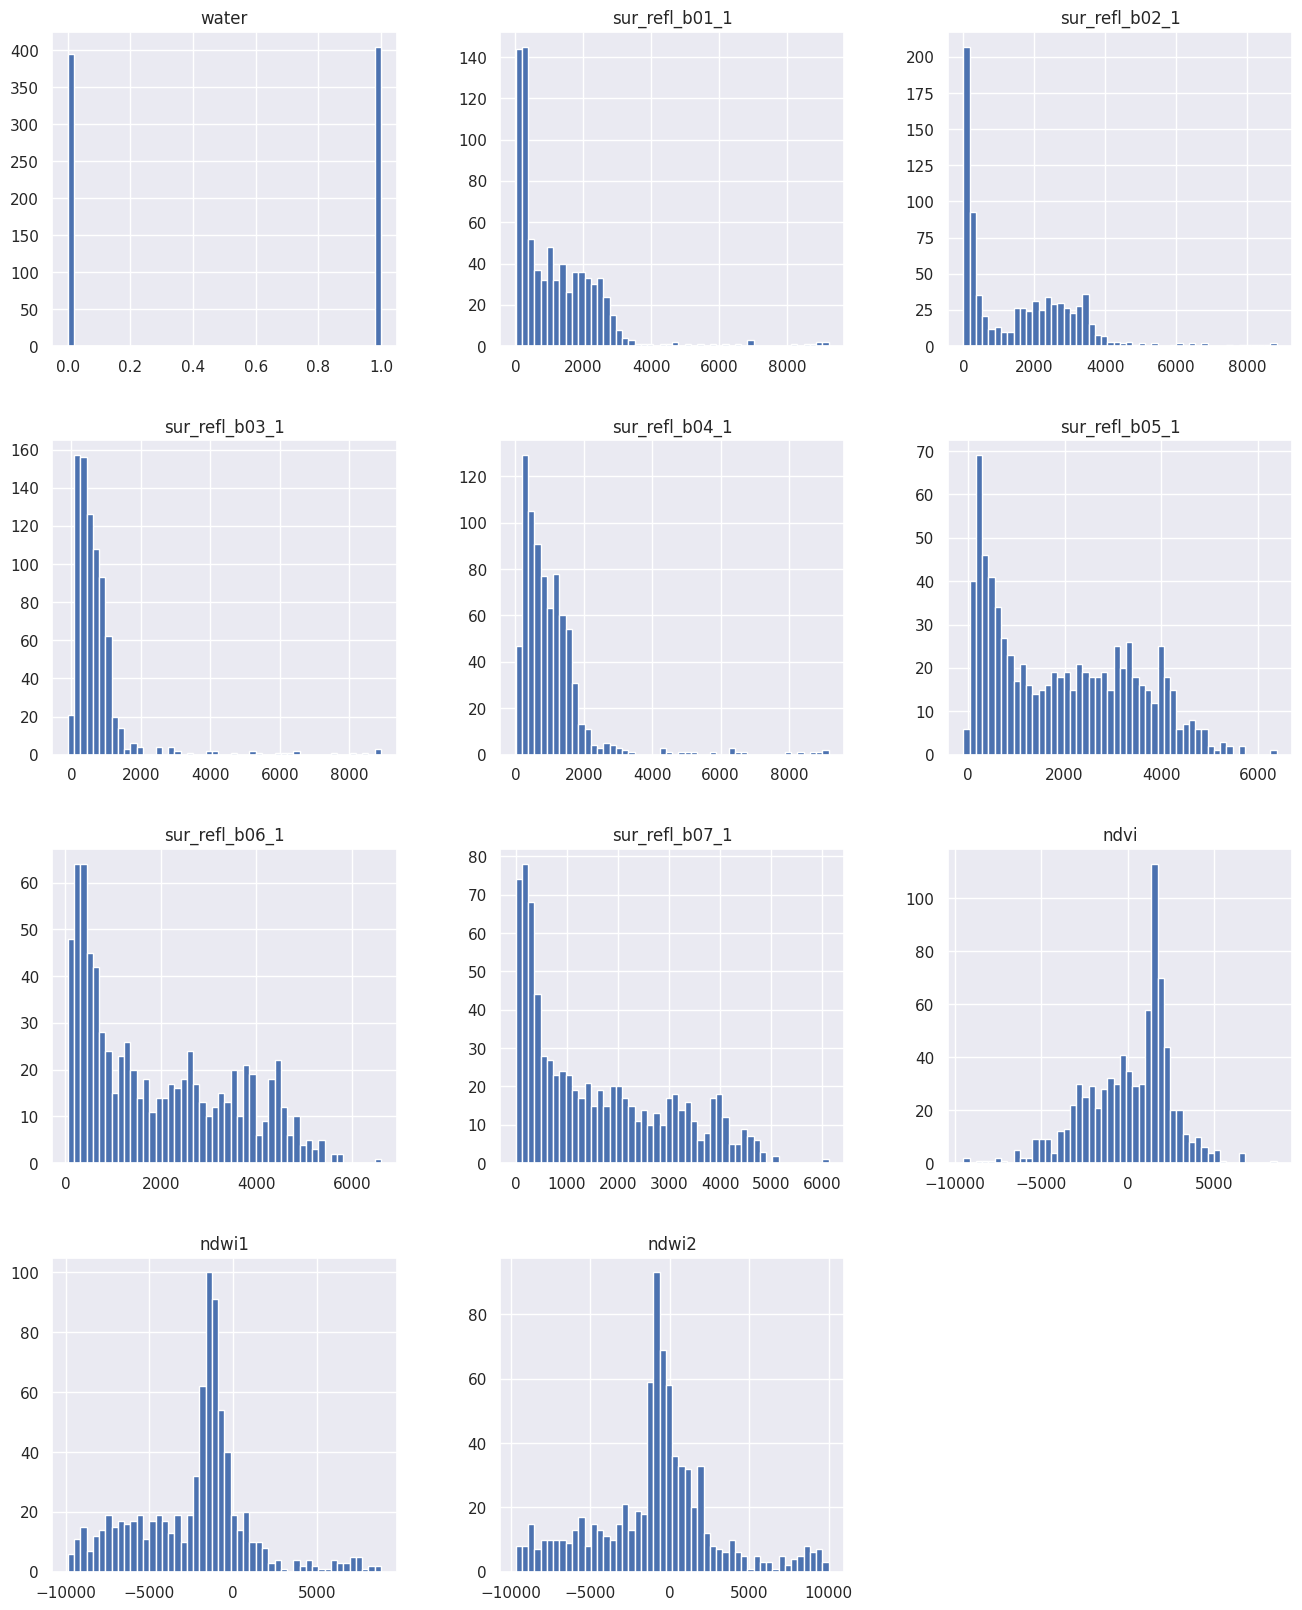

In [10]:
df_pandas.hist(figsize=(16, 20), bins=50)

In [11]:
# correlation with dataset - target value
corr = df_pandas.corr()['water']
corr.to_csv('output/correlation.csv')
corr

water             1.000000
sur_refl_b01_1   -0.604949
sur_refl_b02_1   -0.780173
sur_refl_b03_1   -0.315886
sur_refl_b04_1   -0.431506
sur_refl_b05_1   -0.813848
sur_refl_b06_1   -0.769546
sur_refl_b07_1   -0.720314
ndvi             -0.751600
ndwi1            -0.536501
ndwi2            -0.382001
Name: water, dtype: float64

In [12]:
# full correlation table
df_pandas.corr().style.background_gradient(cmap='viridis')

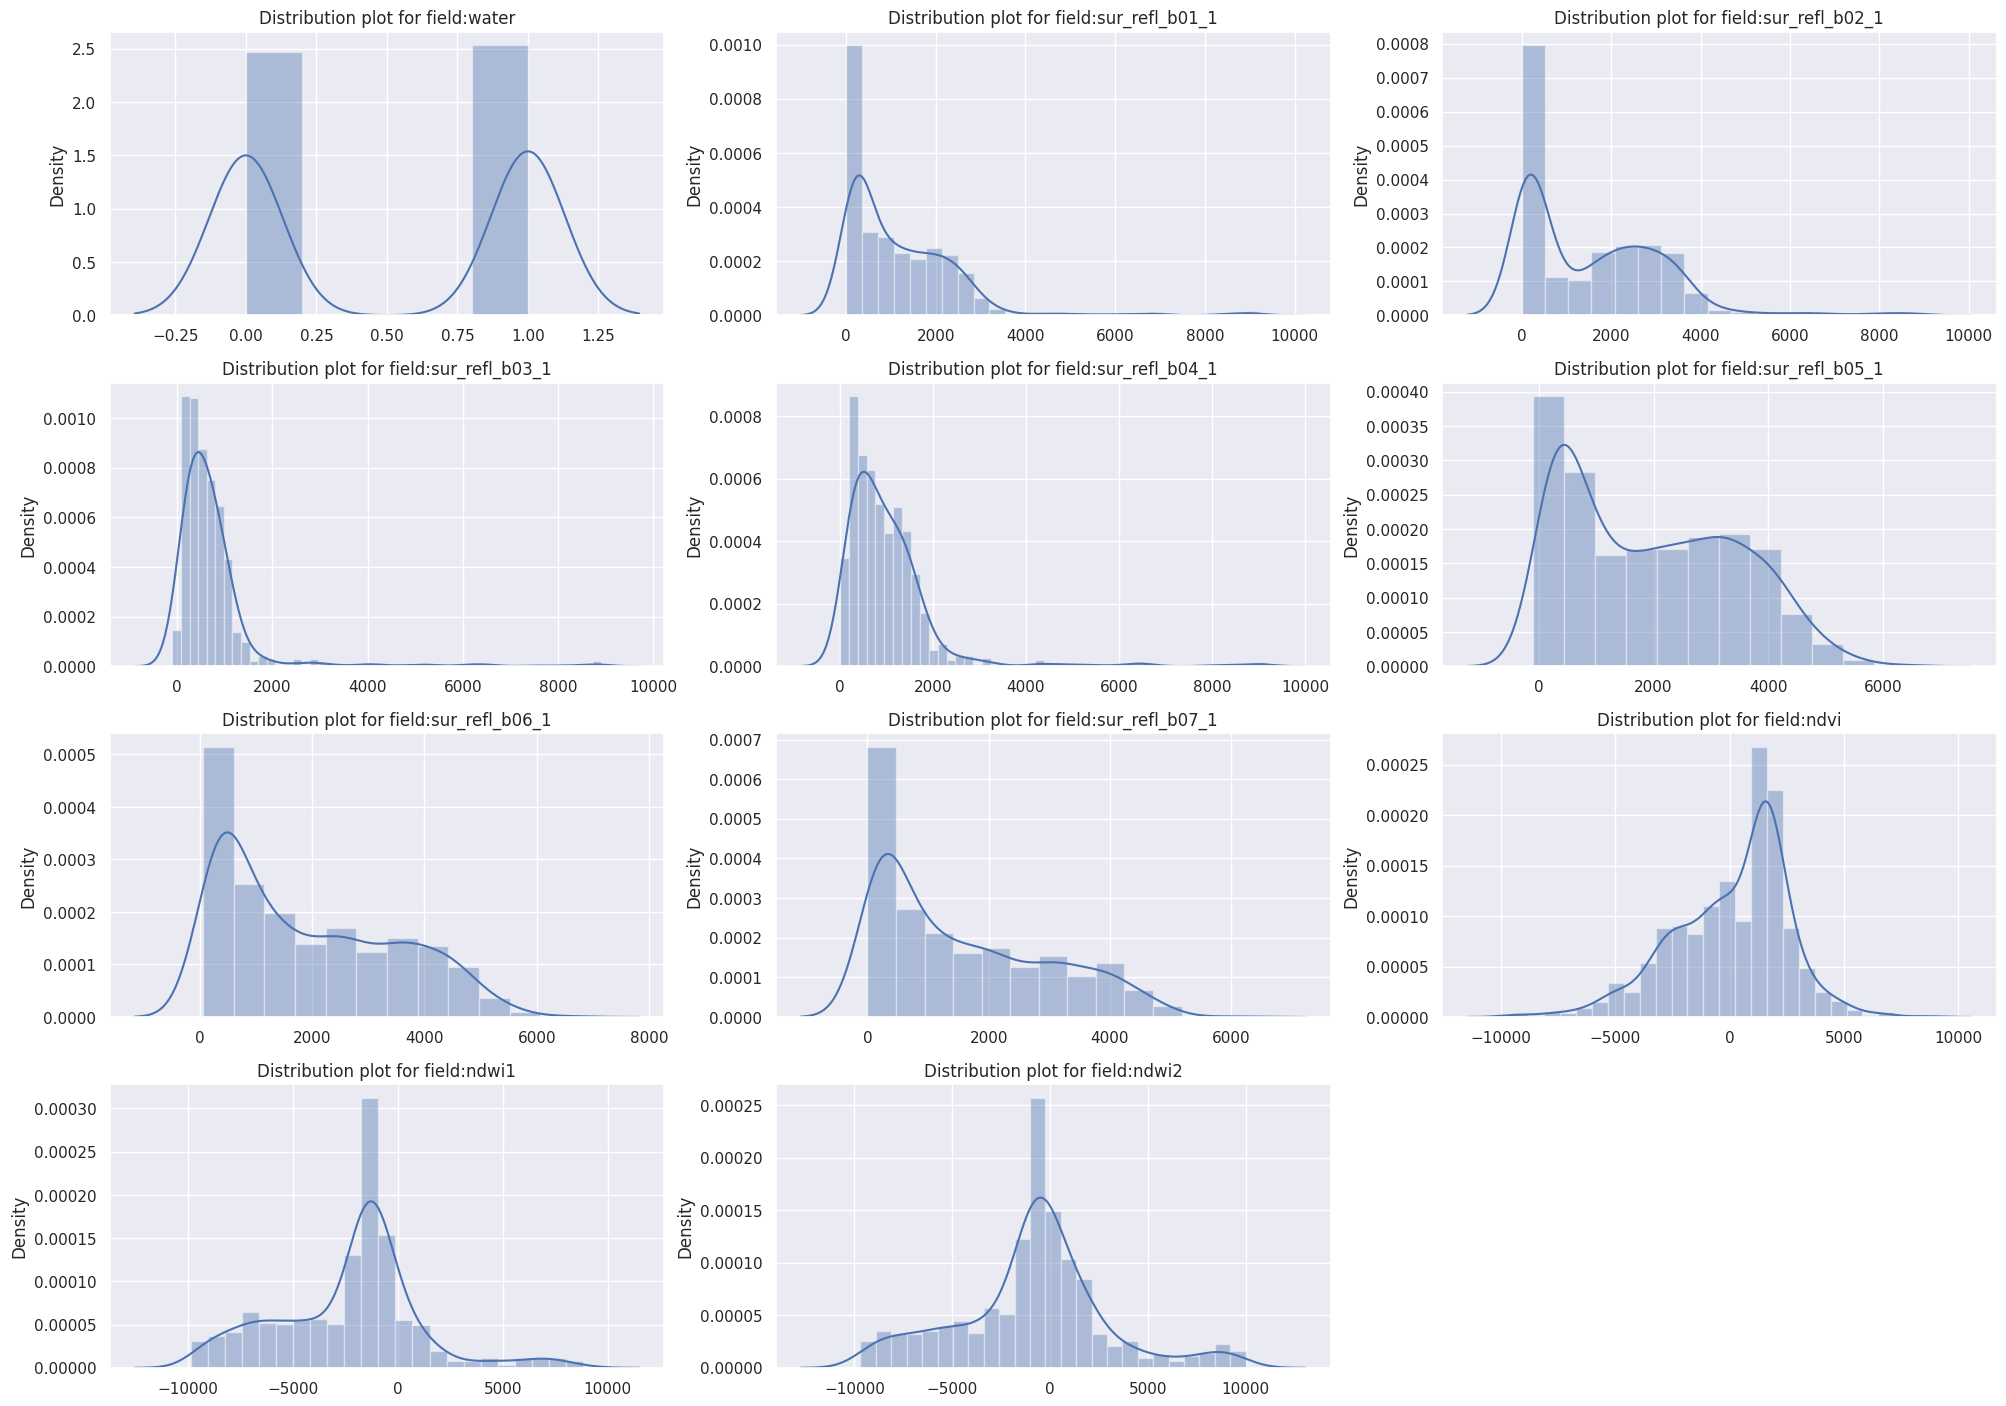

In [13]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df_pandas[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

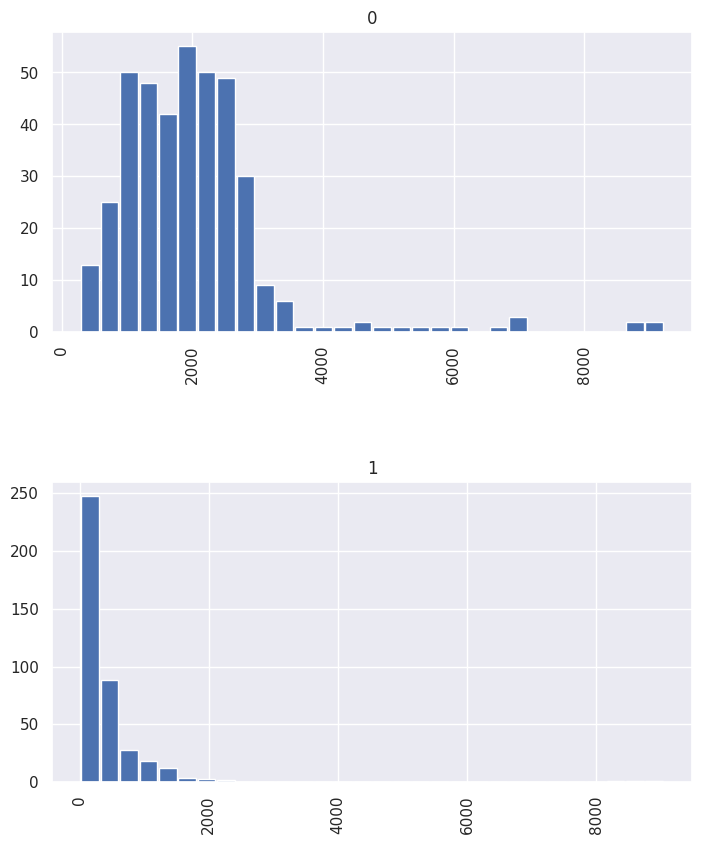

In [14]:
df_pandas.hist(column='sur_refl_b01_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

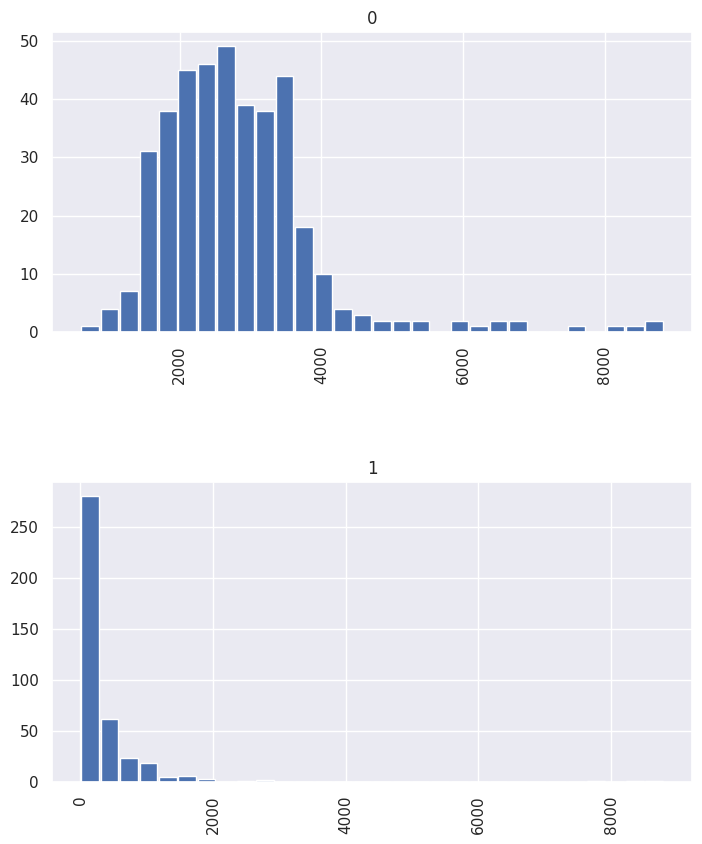

In [15]:
df_pandas.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

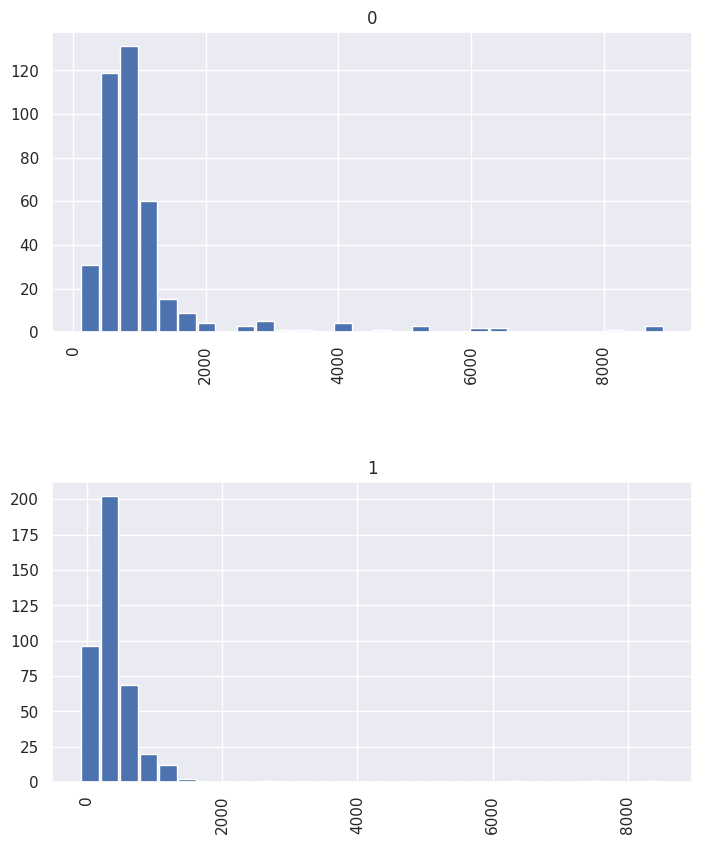

In [16]:
df_pandas.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)

## 5. Split Dataset

In [17]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

CPU times: user 845 ms, sys: 22.1 ms, total: 867 ms
Wall time: 5.84 s


In [18]:
train_dataset.head()

water  sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  sur_refl_b04_1  \
0      0            2031            3113             776            1200   
1      1             410             494             183             319   
2      0            1609            2615             797            1000   
3      0            2593            3315            1250            1944   
4      0            2485            3365             905            1527   

   sur_refl_b05_1  sur_refl_b06_1  sur_refl_b07_1  ndvi  ndwi1  ndwi2  
0            3626            3480            2957  2103   -556    257  
1             295             329             307   929   2004   2334  
2            2143            1708            1107  2381   2098   4051  
3            3923            4194            3909  1222  -1170   -822  
4            4520            4646            4137  1504  -1599  -1029

In [19]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

## 6. Training

In [20]:
rfr = RandomForestClassifier()

In [21]:
# Parameters for grid search
para = {
    "n_estimators": [100, 300, 1000],
    "max_depth": [2, 4],#, 6, 8],
    "min_samples_split": [2],#, 4, 6, 8],
    "min_samples_leaf": [2],#, 4, 6, 8],
    "random_state": [0],#, 42]
}

# Grid search object
grid = GridSearchCV(rfr, para, cv=5, n_jobs=-1, verbose=1)

# Fitting the grid search object
grid.fit(X_train, y_train)

# Best parameters
print(grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}


In [22]:
model_rf = RandomForestClassifier(**grid.best_params_)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, random_state=0)

## 7. Making Predictions

In [23]:
# Make predictions
prediction_test = model_rf.predict(X_test)
print(metrics.accuracy_score(y_test, prediction_test))

0.985


## 8. XAI

In [24]:
%%time
from sklearn.inspection import permutation_importance

permutation_importance_results = permutation_importance(model_rf,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 1.58 s, sys: 38.1 ms, total: 1.62 s
Wall time: 1.63 s


Text(0.5, 0, 'Permutation Importance')

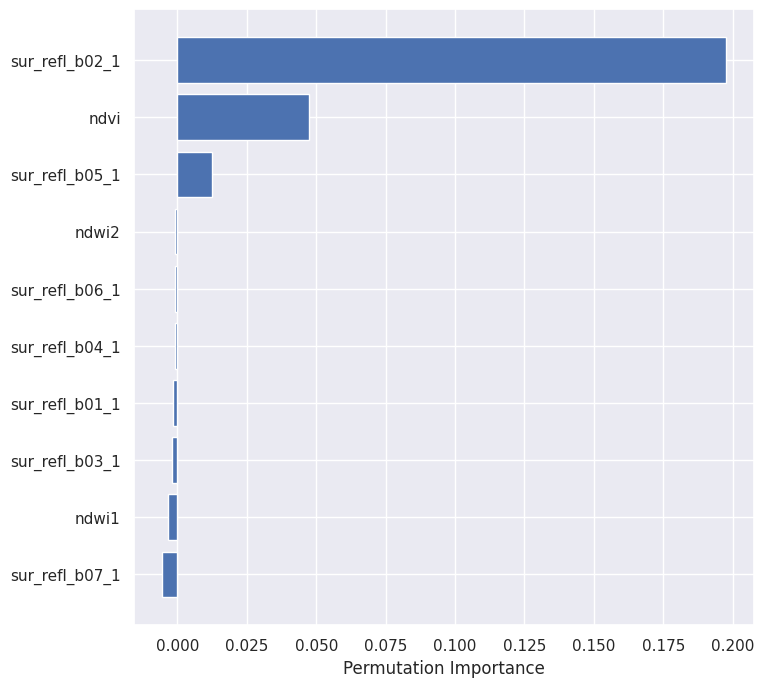

In [25]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [26]:
import shap
import lime

In [27]:
explainer = shap.TreeExplainer(model_rf, data=X_train)
shap_values = explainer(X_test)

In [28]:
X_train.shape, X_test.shape, shap_values.shape

((800, 10), (200, 10), (200, 10, 2))

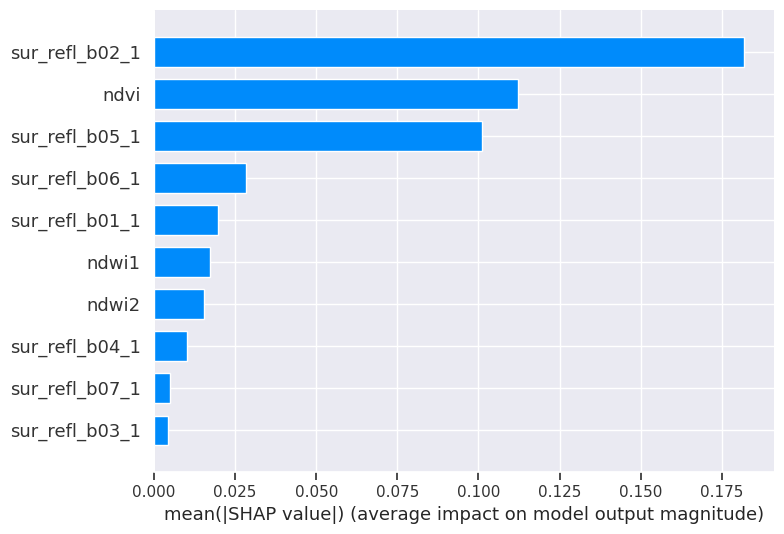

In [29]:
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar", max_display=X_test.shape[1])

In [30]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [31]:
predicted_ndvi_outlier = output_interesting_idx(X_test, 'ndvi', 6000)
predicted_ndvi_outlier

sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  sur_refl_b04_1  \
6               697            3157             395             773   
119             680            2784             384             719   
167             400            1604             213             352   

     sur_refl_b05_1  sur_refl_b06_1  sur_refl_b07_1  ndvi  ndwi1  ndwi2  
6              3229            2746            1866  6382    696   2570  
119            3091            2542            1524  6073    454   2924  
167            1696            1194             628  6007   1465   4372

In [32]:
def plot_force(explainer, idx, to_predict, df):
  shortened_features = ['sr1', 'sr2', 'sr3', 'sr4', 'sr5', 'sr6', 'sr7', 'ndvi', 'ndwi1', 'ndwi2']
  single_prediction = explainer(to_predict.iloc[idx, :])
  print(f'Model prediction: {df.iloc[idx]["water"]}')
  shap.force_plot(explainer.expected_value[1],
                    single_prediction.values[:, 1],
                    to_predict.iloc[idx, :],
                    # df_to_predict.to_numpy()[0,:],
                    feature_names=shortened_features,
                    matplotlib=True,
                    show=True)

Model prediction: 1


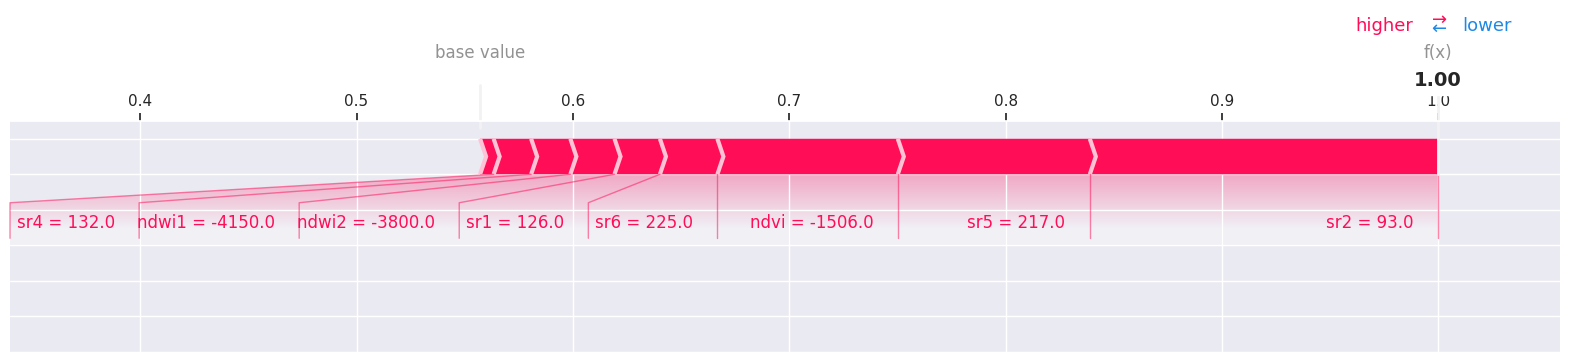

In [33]:
plot_force(explainer, 0, X_test, test_dataset)

Model prediction: 1


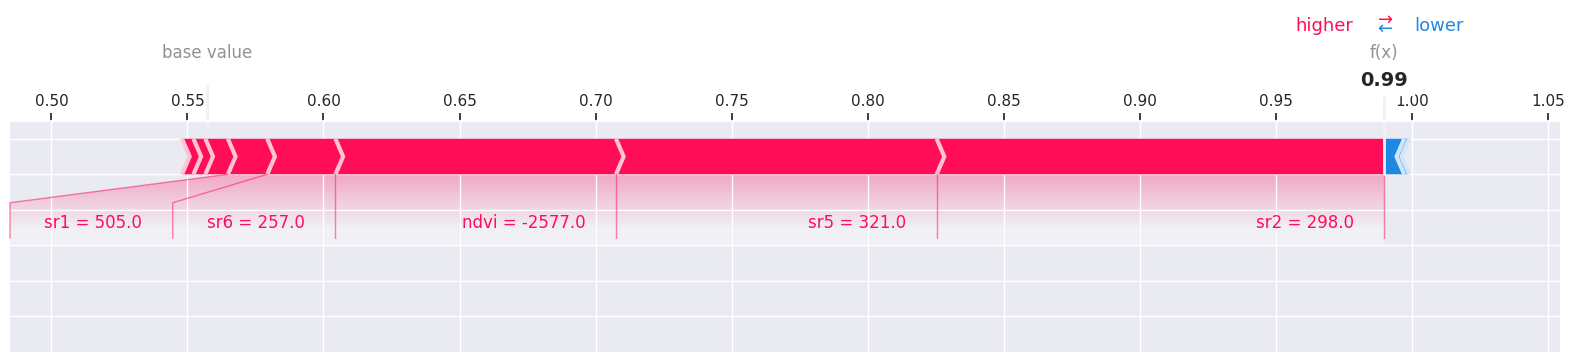

In [34]:
plot_force(explainer, 1, X_test, test_dataset)

Model prediction: 0


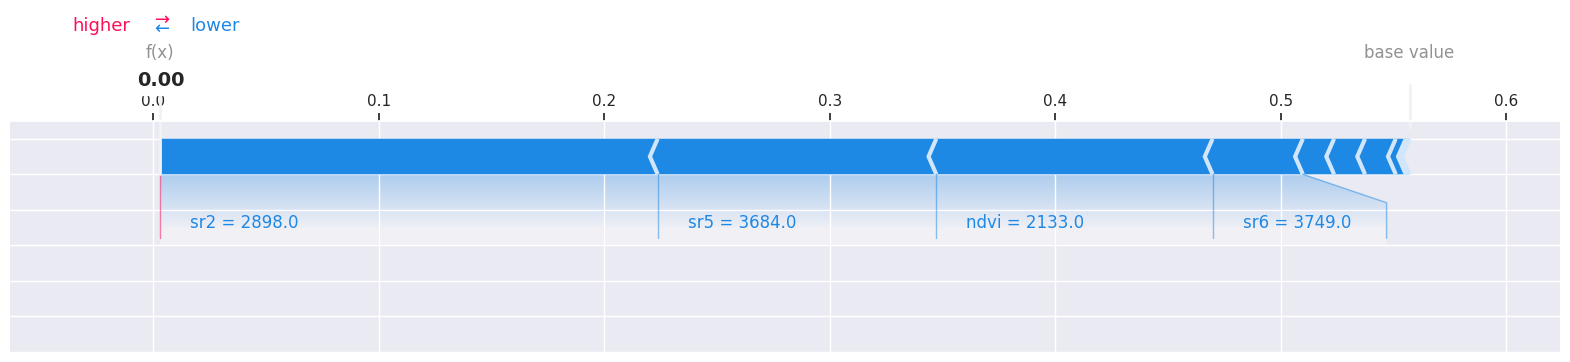

In [35]:
plot_force(explainer, 100, X_test, test_dataset)

In [36]:
shortened_features = ['sr1', 'sr2', 'sr3', 'sr4', 'sr5', 'sr6', 'sr7', 'ndvi', 'ndwi1', 'ndwi2']
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values,
                                                   mode='classification',
                                                   feature_names=shortened_features,
                                                   class_names=['Not water', 'Water'])

In [37]:
predict_rf_prob = lambda x: model_rf.predict_proba(x).astype(np.float32)

In [38]:
row_example_0_lime = lime_explainer.explain_instance(X_test.iloc[0].values,
                                                     predict_rf_prob,
                                                     num_features=10)
row_example_0_lime.show_in_notebook()

In [39]:
row_example_1_lime = lime_explainer.explain_instance(X_test.iloc[1].values,
                                                     predict_rf_prob,
                                                     num_features=10)
row_example_1_lime.show_in_notebook()

In [40]:
row_example_1_lime = lime_explainer.explain_instance(X_test.iloc[10].values,
                                                     predict_rf_prob,
                                                     num_features=10)
row_example_1_lime.show_in_notebook()

In [41]:
model_rf.predict_proba(X_test)

array([[2.87617972e-04, 9.99712382e-01],
       [1.02114139e-02, 9.89788586e-01],
       [1.83469313e-02, 9.81653069e-01],
       [9.96828821e-01, 3.17117899e-03],
       [9.96563334e-01, 3.43666571e-03],
       [2.23130465e-02, 9.77686953e-01],
       [9.87276848e-01, 1.27231519e-02],
       [9.94072738e-01, 5.92726196e-03],
       [8.11949238e-01, 1.88050762e-01],
       [9.86958020e-01, 1.30419800e-02],
       [4.94766580e-01, 5.05233420e-01],
       [2.87617972e-04, 9.99712382e-01],
       [9.96828821e-01, 3.17117899e-03],
       [3.80306250e-01, 6.19693750e-01],
       [1.75791431e-03, 9.98242086e-01],
       [9.42692779e-01, 5.73072206e-02],
       [9.95789685e-01, 4.21031529e-03],
       [2.87617972e-04, 9.99712382e-01],
       [9.96464324e-01, 3.53567561e-03],
       [9.96828821e-01, 3.17117899e-03],
       [8.68975857e-04, 9.99131024e-01],
       [2.87617972e-04, 9.99712382e-01],
       [9.95789685e-01, 4.21031529e-03],
       [9.96234669e-01, 3.76533069e-03],
       [3.769036

## Visualize

In [42]:
from huggingface_hub import snapshot_download

powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

In [43]:
fileList = sorted([file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'sur_refl' in file])
fileList

['/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/IL.2001155.Powell.20220871535-sur_refl_b01_1.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/IL.2001155.Powell.20220871535-sur_refl_b02_1.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/IL.2001155.Powell.20220871535-sur_refl_b03_1.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/IL.2001155.Powell.20220871535-sur_refl_b04_1.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/IL.2001155.Powell.20220871535-s

In [44]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

In [45]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 385 ms, sys: 57.8 ms, total: 443 ms
Wall time: 489 ms


In [46]:
print(im.shape)

(1690000, 10)


In [47]:
raster_dataframe = pd.DataFrame(im, columns=v_names, dtype=np.float32)
raster_dataframe

sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  sur_refl_b04_1  \
0                1547.0          2461.0           857.0          1256.0   
1                1474.0          2377.0           857.0          1256.0   
2                1474.0          2377.0           846.0          1230.0   
3                1494.0          2461.0           846.0          1230.0   
4                1494.0          2461.0           846.0          1230.0   
...                 ...             ...             ...             ...   
1689995          2211.0          2826.0          1080.0          1796.0   
1689996          2209.0          2801.0          1028.0          1791.0   
1689997          2358.0          2979.0          1028.0          1791.0   
1689998          2425.0          3069.0          1117.0          1876.0   
1689999          2402.0          3038.0          1117.0          1876.0   

         sur_refl_b05_1  sur_refl_b06_1  sur_refl_b07_1    ndvi   ndwi1  \
0                2684.0          2730.0          2222.0  2280.0  -518.0   
1                2684.0          2730.0          2222.0  2344.0  -691.0   
2                2630.0          2613.0          2098.0  2344.0  -472.0   
3                2630.0          2613.0          2098.0  2445.0  -299.0   
4                2630.0          2613.0          2098.0  2445.0  -299.0   
...                 ...             ...             ...     ...     ...   
1689995          3650.0          4266.0          3862.0  1220.0 -2030.0   
1689996          3633.0          4223.0          3863.0  1181.0 -2024.0   
1689997          3633.0          4223.0          3863.0  1163.0 -1727.0   
1689998          3747.0          4345.0          3919.0  1172.0 -1721.0   
1689999          3747.0          4345.0          3919.0  1169.0 -1770.0   

          ndwi2  
0         510.0  
1         337.0  
2         623.0  
3         796.0  
4         796.0  
...         ...  
1689995 -1549.0  
1689996 -1593.0  
1689997 -1292.0  
1689998 -1216.0  
1689999 -1266.0  

[1690000 rows x 10 columns]

In [48]:
def predictRaster(dataframe, colsToDrop=None):
    """
    Function given a raster in the form of a
    GPU/CPU-bound data frame then perform
    predictions given the loaded model.

    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = model_rf.predict(df).astype(np.int16)
    predictionsProbs = model_rf.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs

In [49]:
predictedRaster, predictedProbaRaster = predictRaster(raster_dataframe)

Making predictions from raster


In [50]:
raster_shape = (1300, 1300)
predictedRasterNdArray = np.asarray(predictedRaster)
predictedRasterMatrix = predictedRasterNdArray.reshape(raster_shape)
predictedRasterMatrix.shape

(1300, 1300)

In [51]:
qa = [file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [52]:
raster_qad = np.where(qaMask == 0, predictedRasterMatrix, 255)

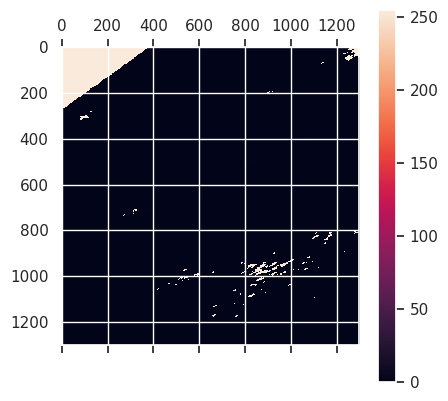

In [53]:
plt.matshow(raster_qad)
plt.colorbar()

In [54]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

predictedPath = 'PowellPredictedWaterMask.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(raster_qad)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [55]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2024-04-12 01:01:04--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py.1’

folium_helper.py.1  100%[===================>]   6.04K  --.-KB/s    in 0s      

2024-04-12 01:01:05 (83.8 MB/s) - ‘folium_helper.py.1’ saved [6189/6189]



In [58]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 13.5 MB/s eta 0:00:00


In [66]:
import folium_helper
import folium
from folium import plugins

In [63]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [64]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


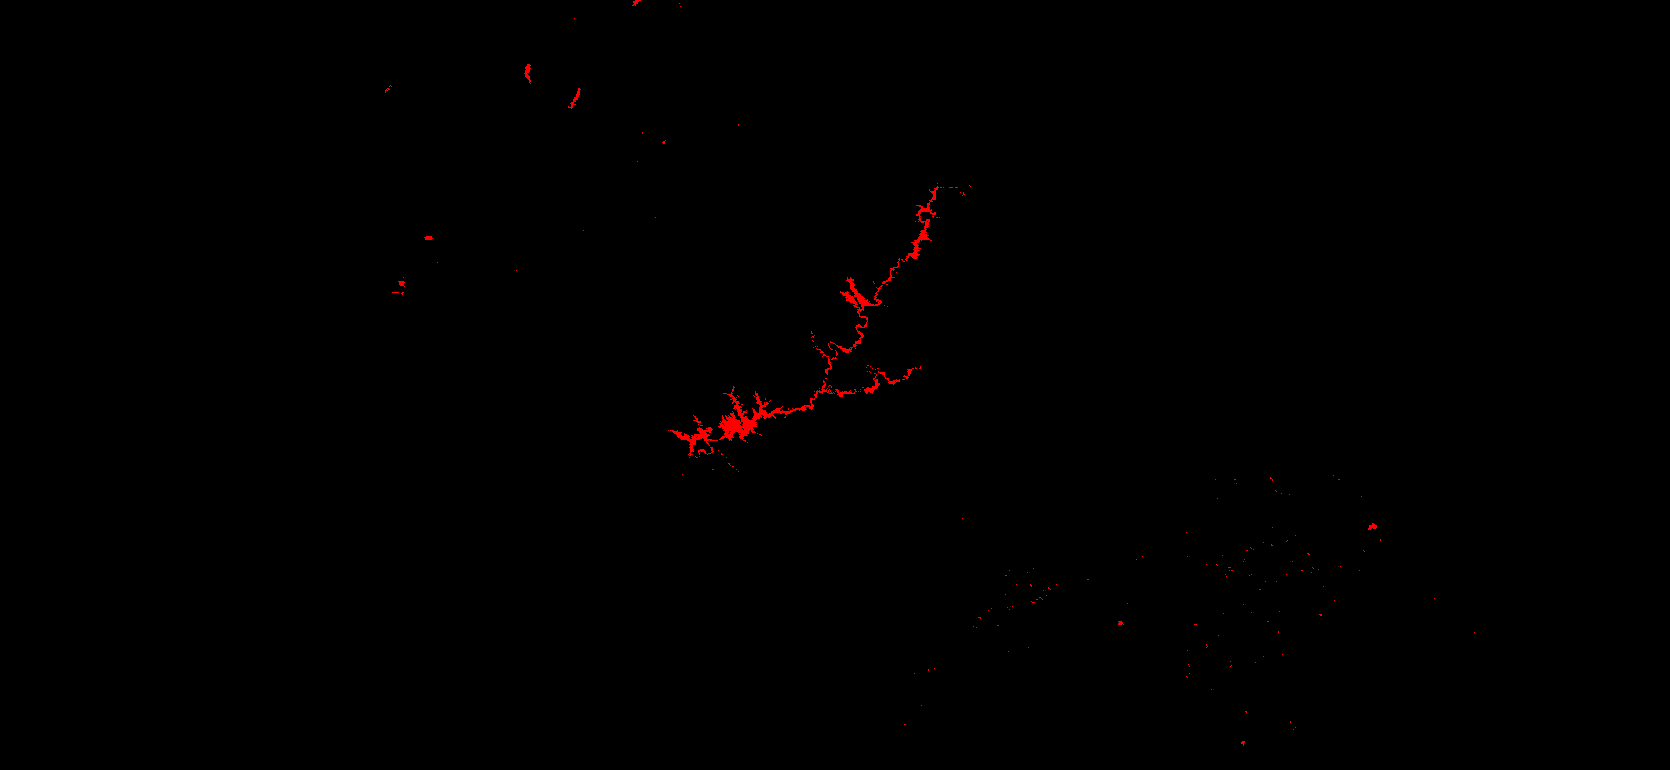
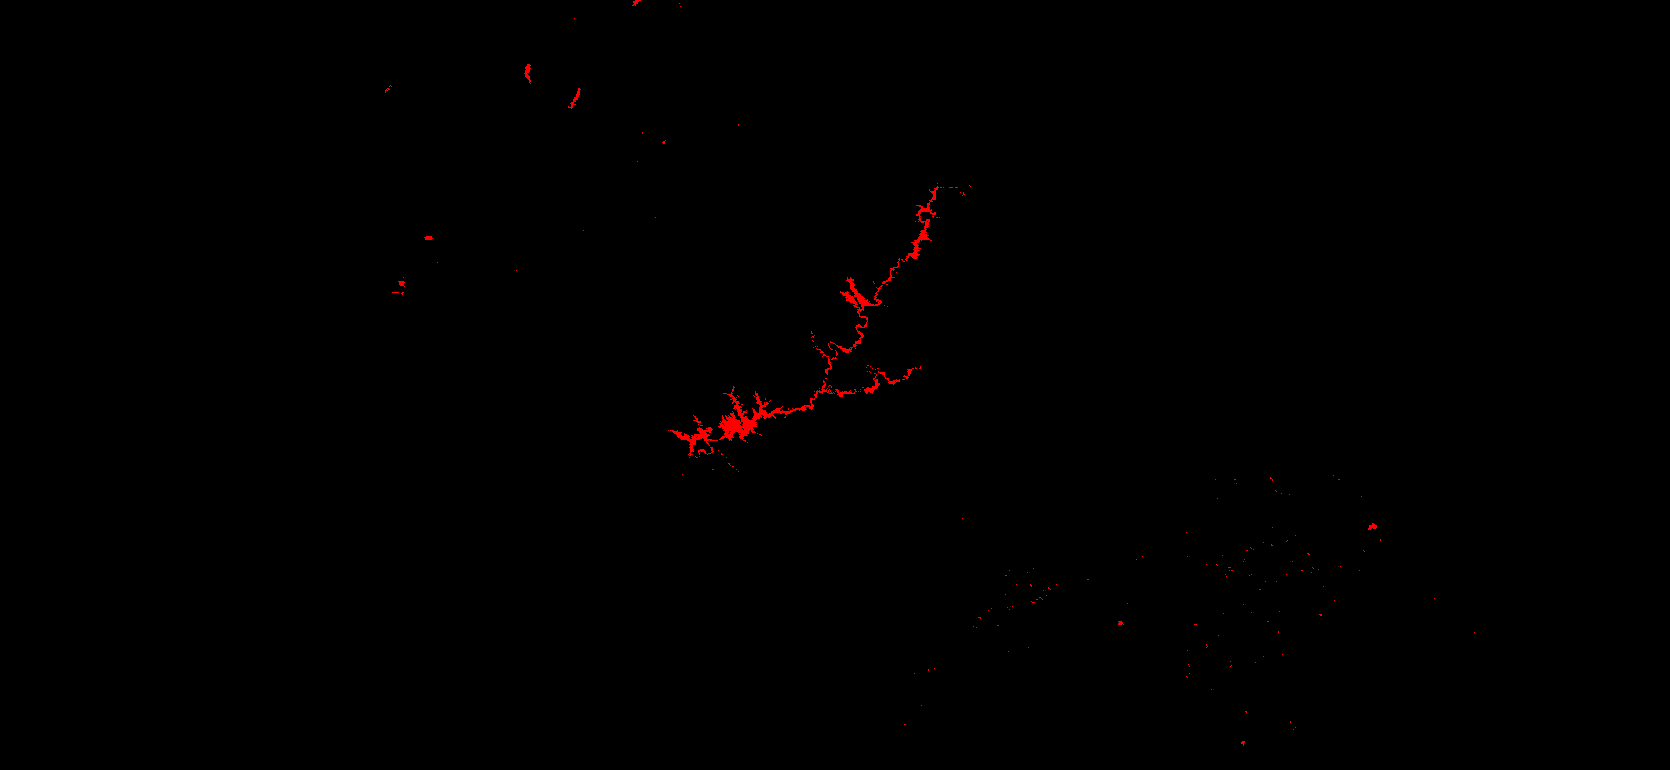

In [67]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification RF predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())